In [399]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


## 0. Solutions to the TOV-Equations

In [400]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Interpolate all the data (in oversampled form) to allow for a linear grid
m_intp     = interpolate.interp1d(R, m,     kind='cubic', bounds_error=False, fill_value='extrapolate')
P_intp     = interpolate.interp1d(R, P,     kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_intp   = interpolate.interp1d(R, rho,   kind='cubic', bounds_error=False, fill_value='extrapolate')
alpha_intp = interpolate.interp1d(R, alpha, kind='cubic', bounds_error=False, fill_value='extrapolate')
psi_intp   = interpolate.interp1d(R, psi,   kind='cubic', bounds_error=False, fill_value='extrapolate')


## 1. Linear Grid Definition

In [401]:
# Define the number of data points in each grid (increasingly dense), selected such to include the previous ones
nb_of_grids = 4
n_grid1     = 2
n_grid2     = 2 * n_grid1 - 1
n_grid3     = 2 * n_grid2 - 1
n_gridlast  = 2 * n_grid3 - 1

# Define the range
r_min = np.min(R)
r_max = np.max(R)

# Grid definition
r_grid1    = np.linspace(r_min, r_max, n_grid1)
r_grid2    = np.linspace(r_min, r_max, n_grid2)
r_grid3    = np.linspace(r_min, r_max, n_grid3)
r_gridlast = np.linspace(r_min, r_max, n_gridlast)

# Define a fine test grid (a fine grid to determine a ground truth solution, and to show the uncertainty between data points)
n_grid_test = 5000
r_grid_test = np.linspace(r_min, r_max, n_grid_test)


In [402]:
# Function definitions:
# 1. Construction of the design matrix
def construct_design_matrix(S1, dS1, r_domain, basis_func, laplacian, psi, N):
    # Definition of k_squared and the source term
    k_squared   = - S1/psi**(2)
    source_term = dS1 / psi

    # Lambdify the basis functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    
    # Initialization of the design matrix
    design_matrix = np.zeros((len(r_domain), N))
    basis_func_matrix = np.zeros((len(r_domain), N))

    for i in range(1, N):
        # Define the first part of the operator
        operator_part_1 = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))(r_domain, i, max(r_domain))
        operator_part_2 = -k_squared*basis_func_lambd(r_domain, i, max(r_domain))
    
        design_matrix[:,i] = operator_part_1 + operator_part_2
        basis_func_matrix[:,i] = basis_func_lambd(r_domain, i, max(r_domain))

    return basis_func_matrix, design_matrix, source_term

# 2. Solving the ordinary differential equation
def solve_ode(basis_func_matrix, design_matrix, y, S, L):
    # Define the (inverse) squared lambda and sigma matrices
    Sneg2 = np.linalg.matrix_power(S, -2)
    Lneg2 = np.linalg.matrix_power(L, -2)
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    A = design_matrix.T @ Sneg2 @ design_matrix + Lneg2
    b = design_matrix.T @ Sneg2 @ y
    
    # Solve the system
    w = np.linalg.solve(A, b)
    
    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(A, design_matrix.T)
    source_func_variance_primal = design_matrix @ v
    source_func_variance_primal = np.diag(source_func_variance_primal)
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(A, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v
    solution_variance_primal = np.diag(solution_variance_primal)

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, w, A

## 2. Ground Truth Solution

In [403]:
# ======================================
# Definition of the grid resolution 
# ======================================
r_grid = r_grid_test

# ======================================
# Definition of the density perturbation
# ======================================

# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-2     # Scale factor

# Construction of the perturbation for r_grid_test
center_index  = np.argmin(np.abs(r_grid_test - center_value))
r_centered    = (r_grid_test - r_grid_test[center_index])/r_grid_test[center_index]
gaussian      = amplitude * np.exp(-((r_grid_test - r_grid_test[center_index]) ** 2) / (2 * sigma**2))
density_perturbation_test  = gaussian * r_centered

# Interpolate and define for r_grid
density_perturbation_interp = interpolate.interp1d(r_grid_test, density_perturbation_test, kind='cubic', bounds_error=False, fill_value='extrapolate')
density_perturbation = density_perturbation_interp(r_grid)

# ==========================================
# Sample all the data with the selected grid
# ==========================================
m     = m_intp(r_grid)  
P     = P_intp(r_grid)   
rho   = rho_intp(r_grid)  
alpha = alpha_intp(r_grid) 
psi   = psi_intp(r_grid) 

# Definition of the ODE
S1           = - 2*np.pi*rho
dS1          = -2*np.pi*density_perturbation
k_squared1   = - S1/psi**(2)
source_term1 = dS1 / psi

# ================================================
# Classical Numerical solution
# ================================================
# Interpolate the numerically determined functions
k_squared1_interp   = interpolate.interp1d(r_grid, k_squared1,   kind='cubic', bounds_error=False, fill_value='extrapolate')
source_term1_interp = interpolate.interp1d(r_grid, source_term1, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Conversion of the 2nd order ODE to a 1st order system of ODEs defining a state vector y such that y[0] = u, and y[1] = du/dr
def fun(r, y):
    u   = y[0]
    du  = y[1]
    ddu = k_squared1_interp(r) * u + r * source_term1_interp(r)
    return np.vstack((du, ddu))

# Define the boundary conditions:
def bc(ya, yb):
    r0 = r_grid[0]  # first grid point, e.g. 0.005
    return np.array([ya[0] - r0 * ya[1],  # inner BC: u(r0) - r0*u'(r0)=0
                     yb[0]             ])  # outer BC: u(R) = 0

# Initial guess for solution y: two components, u and du/dr
y_guess  = np.zeros((2, r_grid.size))

# Solve BVP
sol = solve_bvp(fun, bc, r_grid, y_guess)

# Recover f(r) = u(r)/r
u = sol.y[0]
classical_numerical_sol = u / r_grid

# ================================================
# Probabilistic Numerical Solution
# ================================================
# Symbol nomenclature
r = sp.symbols('r')
n = sp.symbols('n')
R_max = sp.symbols('R_max')

# Define the basis functions as the eigen functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)
basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)

# Specificy the problem as: L f = g
laplacian   = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)
operator_1_lamb = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

N = 10
basis_func_matrix, design_matrix, source_term = construct_design_matrix(S1, dS1, r_grid, basis_func, laplacian, psi, N)

# Solve the ODE
small_sigma = 1.0e-6
small_lambd = 1.0e-4
S = small_sigma*np.identity(len(r_grid))
L = small_lambd*np.diag(1 / np.sqrt(np.arange(1, N + 1)))
solution_mean_primal, solution_variance_primal, source_func_primal, source_func_variance_primal, w, A = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)

ground_truth_probabilistic = solution_mean_primal
ground_truth_classical = classical_numerical_sol

## Loop with Increasingly Dense Grids

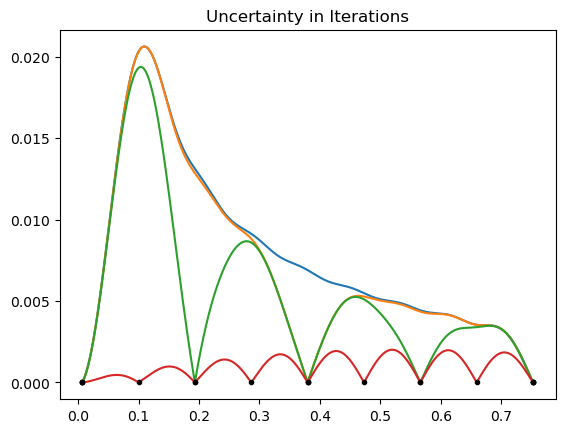

In [404]:
# 3 fields are needed for 1. the number of data points, 2. the sum of absolute errors on the source function and 3. on the solution
statistics_normal_grid = np.zeros((nb_of_grids, 3))

for i in range(nb_of_grids):    
    # Not general:
    if i == 0:
        r_grid = r_grid1
    elif i == 1:
        r_grid = r_grid2
    elif i == 2:
        r_grid = r_grid3
    else:
        r_grid = r_gridlast
    
    # Sample all the data with the selected grid
    m     = m_intp(r_grid)  
    P     = P_intp(r_grid)   
    rho   = rho_intp(r_grid)  
    alpha = alpha_intp(r_grid) 
    psi   = psi_intp(r_grid) 
    density_perturbation = density_perturbation_interp(r_grid)

    # Definition of S1 and dS1
    S1           = -2*np.pi*rho
    dS1          = -2*np.pi*density_perturbation

    # ================================================
    # Probabilistic Numerical Solution: Train
    # ================================================    
    # Symbol nomenclature
    r = sp.symbols('r')
    n = sp.symbols('n')
    R_max = sp.symbols('R_max')
    
    # Define the basis functions as the eigen functions
    basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    
    # Specificy the problem as: L f = g
    laplacian   = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)
    operator_1_lamb = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))
    
    basis_func_matrix, design_matrix, source_term = construct_design_matrix(S1, dS1, r_grid, basis_func, laplacian, psi, N)
    
    # Solve the ODE
    S = small_sigma*np.identity(len(r_grid))
    solution_mean_primal, solution_variance_primal, source_func_primal, source_func_variance_primal, w, A = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)

    # ================================================
    # Probabilistic Numerical Solution: Test
    # ================================================
    # Extend this to do inference on the test data points
    S1           = -2*np.pi*rho_intp(r_grid_test)
    dS1          = -2*np.pi*density_perturbation_interp(r_grid_test)

    # Point estimate
    basis_func_matrix_test, design_matrix_test, source_term_test = construct_design_matrix(S1, dS1, r_grid_test, basis_func, laplacian, psi_intp(r_grid_test), N)
    solution_mean_primal_test = basis_func_matrix_test @ w

    # Uncertainty
    v = np.linalg.solve(A, basis_func_matrix_test.T)
    solution_variance_primal_test = basis_func_matrix_test @ v
    solution_std_primal_test = np.squeeze(np.diag(solution_variance_primal_test))

    # Source function approximation
    source_test = design_matrix_test @ w
    v = np.linalg.solve(A, design_matrix_test.T)
    source_func_std_primal_test = np.sqrt(np.squeeze(np.diag(design_matrix_test @ v)))

    # Visualization
    plt.figure(1)
    plt.plot(r_grid_test, source_func_std_primal_test)
    plt.plot(r_grid, np.zeros_like(r_grid), marker='.', linestyle='none', color='black', label="Sampled Data Points")
    plt.title("Uncertainty in Iterations")
    
    # plt.figure(2)
    # plt.plot(r_grid_test, np.abs(source_test - source_term1_interp(r_grid_test)))
    # plt.plot(r_grid, np.zeros_like(r_grid), marker='.', linestyle='none', color='black', label="Sampled Data Points")

    # Storage
    statistics_normal_grid[i, :] = np.array([len(r_grid), np.sum(np.abs(source_test - source_term1_interp(r_grid_test))), np.sum(np.abs(ground_truth_probabilistic - solution_mean_primal_test))])

## Loop with Adaptive Grid

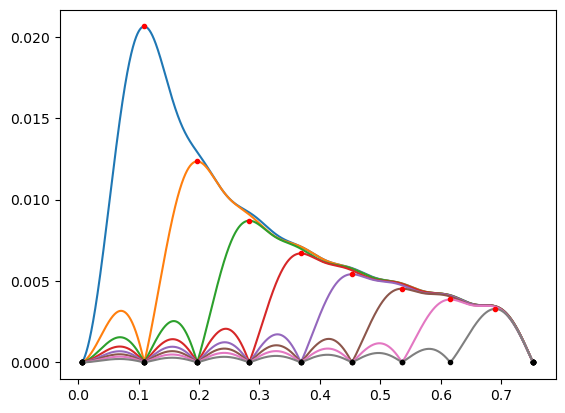

In [405]:
# Intialize the grid from the same discretization grid
r_grid_adaptive = r_grid1

# Additional data points to add:
nb_points_to_add = len(r_gridlast) - len(r_grid1) + 1

# 3 fields are needed for 1. the number of data points, 2. the sum of absolute errors on the source function and 3. on the solution
statistics_adaptive_grid = np.zeros((nb_points_to_add, 3))

for i in range(nb_points_to_add):  
    # Use the adaptive grid
    r_grid = r_grid_adaptive
    
    # Sample all the data with the selected grid
    density_perturbation = density_perturbation_interp(r_grid)
    m     = m_intp(r_grid)  
    P     = P_intp(r_grid)   
    rho   = rho_intp(r_grid)  
    alpha = alpha_intp(r_grid) 
    psi   = psi_intp(r_grid) 

    # Definition of S1 and dS1
    S1           = -2*np.pi*rho
    dS1          = -2*np.pi*density_perturbation
    
    # Symbol nomenclature
    r = sp.symbols('r')
    n = sp.symbols('n')
    R_max = sp.symbols('R_max')
    
    # Define the basis functions as the eigen functions
    basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    
    # Specificy the problem as: L f = g
    laplacian   = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)
    operator_1_lamb = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))
    
    basis_func_matrix, design_matrix, source_term = construct_design_matrix(S1, dS1, r_grid, basis_func, laplacian, psi, N)
    
    # Solve the ODE
    S = small_sigma*np.identity(len(r_grid))
    solution_mean_primal, solution_variance_primal, source_func_primal, source_func_variance_primal, w, A = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)
    
    # Extend this to do inference on the test data points
    S1           = -2*np.pi*rho_intp(r_grid_test)
    dS1          = -2*np.pi*density_perturbation_interp(r_grid_test)
    
    basis_func_matrix_test, design_matrix_test, source_term_test = construct_design_matrix(S1, dS1, r_grid_test, basis_func, laplacian, psi_intp(r_grid_test), N)
    
    solution_mean_primal_test = basis_func_matrix_test @ w
    
    v = np.linalg.solve(A, basis_func_matrix_test.T)
    solution_variance_primal_test = basis_func_matrix_test @ v
    
    solution_std_primal_test = np.squeeze(np.diag(solution_variance_primal_test))
    
    source_test = design_matrix_test @ w
    v = np.linalg.solve(A, design_matrix_test.T)
    source_func_std_primal_test = np.sqrt(np.squeeze(np.diag(design_matrix_test @ v)))
    
    plt.figure(1)
    plt.plot(r_grid_test, source_func_std_primal_test)
    plt.plot(r_grid, np.zeros_like(r_grid), marker='.', linestyle='none', color='black', label="Sampled Data Points")

    statistics_adaptive_grid[i, :] = np.array([len(r_grid_adaptive), np.sum(np.abs(source_test - source_term1_interp(r_grid_test))), np.sum(np.abs(ground_truth_probabilistic - solution_mean_primal_test))])
    
    # Get indices sorted by descending variance
    sorted_indices = np.argsort(source_func_std_primal_test)[::-1]
    
    # Loop over them and find the first r_grid_test value not already in r_grid_adaptive
    for idx in sorted_indices:
        if idx != sorted_indices[0]:
            print("WARNING: Changed collocation point")
        candidate = r_grid_test[idx]
        if candidate not in r_grid_adaptive:
            r_grid_adaptive = np.append(r_grid_adaptive, candidate)
            break

    plt.plot(r_grid_test[idx], source_func_std_primal_test[idx], marker='.', ls='none', color='red')
    
    # Sort the adaptive grid
    r_grid_adaptive = np.sort(r_grid_adaptive)


Text(0.5, 1.0, 'Solution Approximation Error')

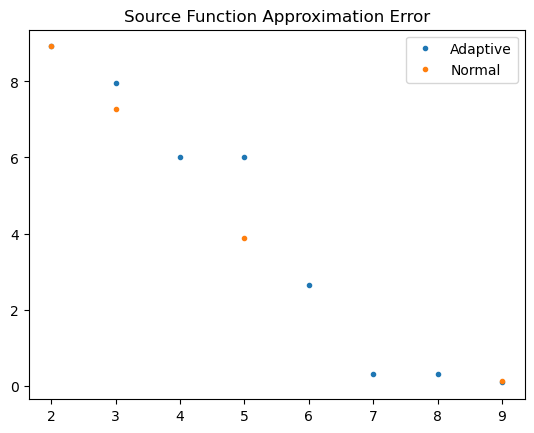

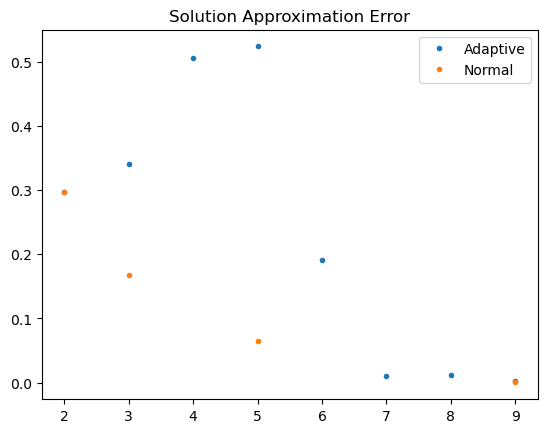

In [406]:
plt.figure(1)
plt.plot(statistics_adaptive_grid[:,0], statistics_adaptive_grid[:,1], marker='.', ls='none', label="Adaptive")
plt.plot(statistics_normal_grid[:,0], statistics_normal_grid[:,1], marker='.', ls='none', label="Normal")
plt.legend()
plt.title("Source Function Approximation Error")

plt.figure(2)
plt.plot(statistics_adaptive_grid[:,0], statistics_adaptive_grid[:,2], marker='.', ls='none', label="Adaptive")
plt.plot(statistics_normal_grid[:,0], statistics_normal_grid[:,2], marker='.', ls='none', label="Normal")
plt.legend()
plt.title("Solution Approximation Error")